Parts of this work resemble: https://www.kaggle.com/jhoward/some-dicom-gotchas-to-be-aware-of-fastai

# **Importing Dependencies**

In [0]:
import glob
import os

import pandas as pd
import matplotlib.pyplot as plt

import tqdm.notebook as tqdm

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)

# **Reading in Metadata & Data Labels**

DICOM files---the type of data we are dealing with here---do not merely contain images (like a slice of a patient's brain), but also a heap of metadata. Using parts of this metadata (specifically, patient IDs) lets us "piece together" *full* scans of patient brains from otherwise unrelated images.

This step is crucial for our approach: For our sequential model to make use of the spatial relations inherent in CT scans, we must first reconstruct those spatial relations.

In [0]:
labels = pd.read_feather("./labels_jhoward.fth")
train_metadata = pd.read_feather("./df_trn.fth")

In [0]:
# Add .png extension to file IDs in the "labels" DataFrame
labels = labels[["ID", "any"]]
labels["ID"] = labels["ID"].str[:] + ".png"

In [0]:
# Verify that the above cell executed correctly
labels.head()

,ID,any
0,ID_000039fa0.png,0
1,ID_00005679d.png,0
2,ID_00008ce3c.png,0
3,ID_0000950d7.png,0
4,ID_0000aee4b.png,0


# **EDA**

In [0]:
# We find that there are ~700,000 images, 14% of which contain hemorrhages
# (see "mean" (note that hemorrhages have label 1 while no-hemorrhages have label 0))
labels.describe()

,any
count,674258.000000
mean,0.144015
std,0.351105
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [0]:
# For reference, the full metadata contained in 5 DICOM files
train_metadata.head()

,SOPInstanceUID,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,Rows,Columns,PixelSpacing,BitsAllocated,BitsStored,HighBit,PixelRepresentation,WindowCenter,WindowWidth,RescaleIntercept,RescaleSlope,fname,MultiImagePositionPatient,ImagePositionPatient1,ImagePositionPatient2,MultiImageOrientationPatient,ImageOrientationPatient1,ImageOrientationPatient2,ImageOrientationPatient3,ImageOrientationPatient4,ImageOrientationPatient5,MultiPixelSpacing,PixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1
0,ID_231d901c1,CT,ID_b81a287f,ID_dd37ba3adb,ID_15dcd6057a,,-125.0,1.0,1,MONOCHROME2,512,512,0.488281,16,16,15,1,40.0,100.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_231d901c1.dcm,1,-123.101000,104.307000,1,0.0,0.0,0.0,0.984808,-0.173648,1,0.488281,-1024,3263,171.462490,828.102464,0.164074,NaN,NaN,NaN,NaN
1,ID_994bc0470,CT,ID_400facde,ID_c5277f0c63,ID_4ba12c2161,,-125.0,1.0,1,MONOCHROME2,512,512,0.488281,16,12,11,0,47.0,80.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_994bc0470.dcm,1,53.628222,223.572015,1,0.0,0.0,0.0,0.933580,-0.358368,1,0.488281,0,2507,430.418091,599.742963,0.198139,1.0,47.0,1.0,80.0
2,ID_127689cce,CT,ID_42910d3d,ID_db93ade25b,ID_c4b4931314,,-125.0,1.0,1,MONOCHROME2,512,512,0.488281,16,16,15,1,30.0,80.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_127689cce.dcm,1,-123.646240,124.321068,1,0.0,0.0,0.0,0.972370,-0.233445,1,0.488281,-2000,2810,12.801376,1209.046168,0.250923,NaN,NaN,NaN,NaN
3,ID_25457734a,CT,ID_329aafa7,ID_8dd6d32f3b,ID_116558f409,,-114.0,1.0,1,MONOCHROME2,512,512,0.445312,16,12,11,0,36.0,80.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_25457734a.dcm,1,-6.000000,171.999939,1,0.0,0.0,0.0,1.000000,0.000000,1,0.445312,0,2647,566.557011,610.152845,0.298386,1.0,36.0,1.0,80.0
4,ID_81c9aa125,CT,ID_6b544c3c,ID_2685c5d5c0,ID_f56d7bd0f9,,-115.0,1.0,1,MONOCHROME2,512,512,0.449219,16,12,11,0,36.0,80.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_81c9aa125.dcm,1,-1.000000,230.500000,1,0.0,0.0,0.0,1.000000,0.000000,1,0.449219,4,1570,178.512295,358.235071,0.006176,1.0,36.0,1.0,80.0


Sorting by patient ID groups patients together while sorting by "ImagePositionPatient2" sorts the patients' brain slices to be in correct order (thus, the 20 files output by the cell below contain subsequent slices of a single patient's brain).

In [0]:
train_metadata.sort_values(by=["PatientID", "ImagePositionPatient2"]).head(20)

In [0]:
# Verify that we can retrieve the name of our files from the metadata
# (important for matching our PNGs extracted from DICOM files to their metadata)
train_metadata[["SOPInstanceUID", "fname"]].sort_values("SOPInstanceUID")

,SOPInstanceUID,fname
409738,ID_000039fa0,../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_000039fa0.dcm
470057,ID_00005679d,../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_00005679d.dcm
548095,ID_00008ce3c,../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_00008ce3c.dcm
204704,ID_0000950d7,../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_0000950d7.dcm
291987,ID_0000aee4b,../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_0000aee4b.dcm
...,...,...
544908,ID_ffff73ede,../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_ffff73ede.dcm
385867,ID_ffff80705,../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_ffff80705.dcm
674027,ID_ffff82e46,../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_ffff82e46.dcm
52232,ID_ffff922b9,../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_ffff922b9.dcm


Next, we want to know how many slices of a patient's brain the CT scans in our data usually contain. The histogram below tells us that the answer is ~30.

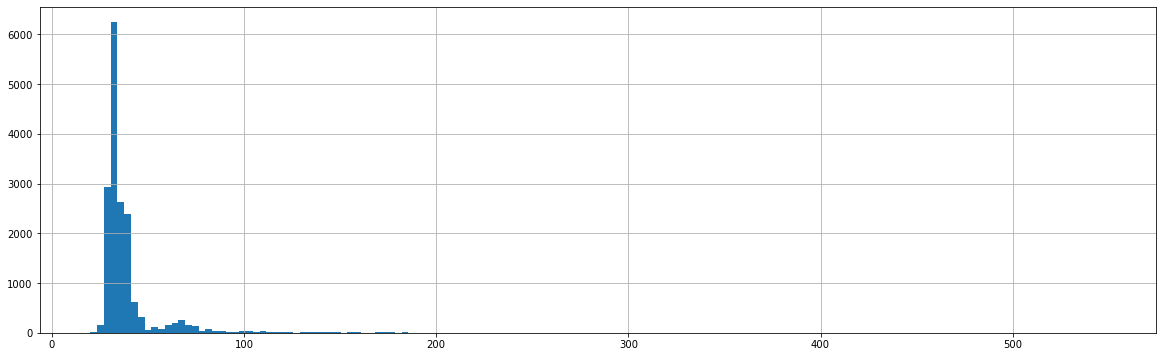

In [0]:
plt.figure(figsize=(20, 6))
train_metadata.groupby("PatientID").Modality.count().hist(bins=150)
plt.show()

# **Data Cleaning**

## **Step 1: Removing Files w/ Incorrect Rescale Intercept**

The rescale intercept of our DICOM files (see metadata) should be -1024 for all files. However, as the histogram below shows, some fraction of files are corrupted: Their rescale intercept is much larger.

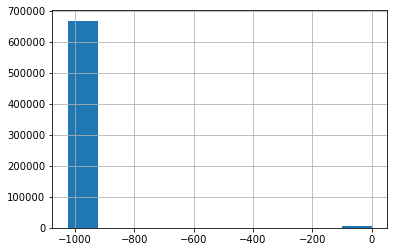

In [0]:
train_metadata.RescaleIntercept.hist()
plt.show()

In [0]:
# We identify the corrupted files in the next three cells
train_metadata.query("RescaleIntercept!=-1024").groupby("PatientID").count().sort_values("SOPInstanceUID")

,SOPInstanceUID,Modality,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,Rows,Columns,PixelSpacing,BitsAllocated,BitsStored,HighBit,PixelRepresentation,WindowCenter,WindowWidth,RescaleIntercept,RescaleSlope,fname,MultiImagePositionPatient,ImagePositionPatient1,ImagePositionPatient2,MultiImageOrientationPatient,ImageOrientationPatient1,ImageOrientationPatient2,ImageOrientationPatient3,ImageOrientationPatient4,ImageOrientationPatient5,MultiPixelSpacing,PixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1
PatientID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ID_b956c8dd,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
ID_11e103d4,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
ID_03ac0e28,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22
ID_57a06f55,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23
ID_cd2e1b47,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_a579ac67,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42
ID_2b35cfb8,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52
ID_00526c11,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52


In [0]:
png_IDs_to_remove = sorted(train_metadata.query("RescaleIntercept!=-1024").SOPInstanceUID.tolist())

In [0]:
png_IDs_to_remove[0:10]

['ID_0007ff5d1',
 'ID_000aa2bce',
 'ID_000bd8380',
 'ID_0012b1611',
 'ID_0015e926e',
 'ID_001bdd8fb',
 'ID_001d4ce1c',
 'ID_0023e98ab',
 'ID_0024b1888',
 'ID_00382ea5e']


Now, we remove the corrupted files and update the metadata & labels to no longer contain references to said files.

In [0]:
# Removing corrupted files
folder_path = "C:/Users/Administrator/Downloads/rsna_stage1_png_128/stage_1_train_images"
for ID in tqdm.tqdm(png_IDs_to_remove):
    os.remove("./rsna_stage1_png_128/stage_1_train_images/{}.png".format(ID))

In [0]:
# Verify that corrupted files have been removed
os.path.isfile("./rsna_stage1_png_128/stage_1_train_images/ID_0007ff5d1.png")

False

In [0]:
# Update labels and metadata
labels = labels[~labels["ID"].isin(png_IDs_to_remove)]
train_metadata = train_metadata[~train_metadata["SOPInstanceUID"].isin(png_IDs_to_remove)]

### **Step 2: Remove Images w/ Low Brain Percentage**

Some images contain virtually no brain matter (that is, they are slices of the patient's skull either above or below their brain). Here, we identify and remove these files.

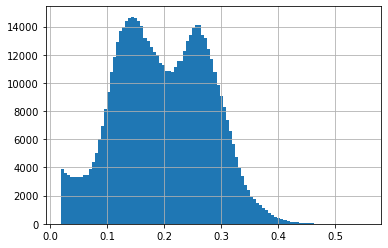

In [0]:
# This histogram shows the percentage of brain matter present in all of our files 
train_metadata.img_pct_window.hist(bins=100)
plt.show()

In [0]:
# We choose to remove images containing less than 2% brain matter
png_IDs_to_remove = train_metadata.query("img_pct_window<0.02").SOPInstanceUID.tolist()

In [0]:
for ID in tqdm.tqdm(png_IDs_to_remove):
    os.remove("./rsna_stage1_png_128/stage_1_train_images/{}.png".format(ID))

In [0]:
# Once again, we update labels and metadata to reflect the changes we have undertaken
labels = labels[~labels["ID"].isin(png_IDs_to_remove)]
train_metadata = train_metadata[~train_metadata["SOPInstanceUID"].isin(png_IDs_to_remove)]

## **Step 3: Create New CSVs**

In [0]:
# Here, we write out the cleaned CSV files for labels and metadata
labels.to_csv("labels_cleaned.csv")
train_metadata.to_csv("train_metadata_cleaned.csv")

## **Step 4: Check that Label File & Metadata File Agree**

We have made substantial udpates to both the label file and to the metadata file. It is now prudent to check that both files still agree with each other to ensure the absence of bugs in the above code.

In [0]:
csv_labels = pd.read_csv("./rsna_stage1_png_128/stage_1_train.csv")
csv_labels = csv_labels.iloc[5::6, :]
csv_labels.head()

,ID,Label
5,ID_63eb1e259_any,0
11,ID_2669954a7_any,0
17,ID_52c9913b1_any,0
23,ID_4e6ff6126_any,0
29,ID_7858edd88_any,0


In [0]:
csv_labels["ID"] = csv_labels["ID"].str.replace("_any", "")
csv_labels.head()

,ID,Label
5,ID_63eb1e259,0
11,ID_2669954a7,0
17,ID_52c9913b1,0
23,ID_4e6ff6126,0
29,ID_7858edd88,0


In [0]:
# Verify that "csv_labels" and "labels" contain the same number of elements
csv_labels_set = set(csv_labels["ID"].tolist())
labels_set = set(labels["ID"].str.replace(".png", "").tolist())

print(len(csv_labels_set))
print(len(labels_set))

In [0]:
# Verify that "csv_labels" and "labels" contain the same elements
# (Indeed they do since their difference is the empty set)
csv_labels_set.symmetric_difference(labels_set)

set()

In [0]:
# Also verify that "metadata_labels" and "labels" contain the same elements
metadata_labels_set = set(train_metadata["SOPInstanceUID"].tolist())
metadata_labels_set.symmetric_difference(labels_set)

set()

In [0]:
# Get rid of .png extension
fnames = glob.glob("./rsna_stage1_png_128/stage_1_train_images/*")
fnames = [fname.replace("./rsna_stage1_png_128/stage_1_train_images\\", "").replace(".png", "") for fname in fnames]
print(fnames[0:10])
print(len(fnames))

['ID_000039fa0', 'ID_00005679d', 'ID_00008ce3c', 'ID_0000950d7', 'ID_0000aee4b', 'ID_0000f1657', 'ID_000178e76', 'ID_00019828f', 'ID_0001dcc25', 'ID_0001de0e8']
641386


In [0]:
fnames_set = set(fnames)

In [0]:
# We have cleaned up the data by deleting ~30,000 images from it
len(fnames_set.symmetric_difference(metadata_labels_set))

32872

## **Get Slice IDs by Patient**

In [0]:
train_metadata.head()

,SOPInstanceUID,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,Rows,Columns,PixelSpacing,BitsAllocated,BitsStored,HighBit,PixelRepresentation,WindowCenter,WindowWidth,RescaleIntercept,RescaleSlope,fname,MultiImagePositionPatient,ImagePositionPatient1,ImagePositionPatient2,MultiImageOrientationPatient,ImageOrientationPatient1,ImageOrientationPatient2,ImageOrientationPatient3,ImageOrientationPatient4,ImageOrientationPatient5,MultiPixelSpacing,PixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1
0,ID_231d901c1,CT,ID_b81a287f,ID_dd37ba3adb,ID_15dcd6057a,,-125.0,1.0,1,MONOCHROME2,512,512,0.488281,16,16,15,1,40.0,100.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_231d901c1.dcm,1,-123.101000,104.307000,1,0.0,0.0,0.0,0.984808,-0.173648,1,0.488281,-1024,3263,171.462490,828.102464,0.164074,NaN,NaN,NaN,NaN
1,ID_994bc0470,CT,ID_400facde,ID_c5277f0c63,ID_4ba12c2161,,-125.0,1.0,1,MONOCHROME2,512,512,0.488281,16,12,11,0,47.0,80.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_994bc0470.dcm,1,53.628222,223.572015,1,0.0,0.0,0.0,0.933580,-0.358368,1,0.488281,0,2507,430.418091,599.742963,0.198139,1.0,47.0,1.0,80.0
2,ID_127689cce,CT,ID_42910d3d,ID_db93ade25b,ID_c4b4931314,,-125.0,1.0,1,MONOCHROME2,512,512,0.488281,16,16,15,1,30.0,80.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_127689cce.dcm,1,-123.646240,124.321068,1,0.0,0.0,0.0,0.972370,-0.233445,1,0.488281,-2000,2810,12.801376,1209.046168,0.250923,NaN,NaN,NaN,NaN
3,ID_25457734a,CT,ID_329aafa7,ID_8dd6d32f3b,ID_116558f409,,-114.0,1.0,1,MONOCHROME2,512,512,0.445312,16,12,11,0,36.0,80.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_25457734a.dcm,1,-6.000000,171.999939,1,0.0,0.0,0.0,1.000000,0.000000,1,0.445312,0,2647,566.557011,610.152845,0.298386,1.0,36.0,1.0,80.0
5,ID_87e8b2528,CT,ID_d6e578fb,ID_ef554a40d0,ID_583e0c9d57,,-125.0,1.0,1,MONOCHROME2,512,512,0.488281,16,12,11,0,40.0,80.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_87e8b2528.dcm,1,-21.516727,156.828114,1,0.0,0.0,0.0,0.996195,-0.087156,1,0.488281,0,2592,464.457344,583.519111,0.248077,1.0,40.0,1.0,80.0


In [0]:
train_metadata_slice_patient_depth = train_metadata[["SOPInstanceUID", "PatientID", "ImagePositionPatient2"]]
train_metadata_slice_patient_depth.head()

,SOPInstanceUID,PatientID,ImagePositionPatient2
0,ID_231d901c1,ID_b81a287f,104.307000
1,ID_994bc0470,ID_400facde,223.572015
2,ID_127689cce,ID_42910d3d,124.321068
3,ID_25457734a,ID_329aafa7,171.999939
5,ID_87e8b2528,ID_d6e578fb,156.828114


In [0]:
patient_slices = dict()
for i, row in tqdm.tqdm(train_metadata_slice_patient_depth.iterrows()):
    if row["PatientID"] not in patient_slices:
        patient_slices[row["PatientID"]] = [(row["ImagePositionPatient2"], row["SOPInstanceUID"])]
    else:
        patient_slices[row["PatientID"]].append((row["ImagePositionPatient2"], row["SOPInstanceUID"]))

In [0]:
patient_slices_sorted = dict()
for i, (key, val) in enumerate(patient_slices.items()):
    val.sort()
    patient_slices_sorted[key] = [ID for depth, ID in val]

In [0]:
patient_slices_sorted["ID_b81a287f"]

['ID_9f601fc5d',
 'ID_19cb96474',
 'ID_496ab2661',
 'ID_06fe4adc5',
 'ID_59bc3960f',
 'ID_aef3564ac',
 'ID_c1f0895bb',
 'ID_c85081ef5',
 'ID_079fef6c2',
 'ID_5ab7d0d9a',
 'ID_54d628968',
 'ID_d3e4638f6',
 'ID_21af3f314',
 'ID_3eb115349',
 'ID_c489f8a64',
 'ID_55e73915f',
 'ID_678a1a095',
 'ID_508bd479e',
 'ID_6609a6357',
 'ID_231d901c1',
 'ID_826c83df4',
 'ID_008507574',
 'ID_f49234b83',
 'ID_ec9041d07',
 'ID_bcbee580c',
 'ID_df700e73f']

In [0]:
train_metadata_slice_patient_depth.query("PatientID == 'ID_b81a287f'").sort_values("ImagePositionPatient2")

,SOPInstanceUID,PatientID,ImagePositionPatient2
214258,ID_9f601fc5d,ID_b81a287f,7.956
427173,ID_19cb96474,ID_b81a287f,13.033
636486,ID_496ab2661,ID_b81a287f,18.110
436756,ID_06fe4adc5,ID_b81a287f,23.187
68576,ID_59bc3960f,ID_b81a287f,28.266
331217,ID_aef3564ac,ID_b81a287f,33.343
503169,ID_c1f0895bb,ID_b81a287f,38.420
467952,ID_c85081ef5,ID_b81a287f,43.497
53879,ID_079fef6c2,ID_b81a287f,48.456
245073,ID_5ab7d0d9a,ID_b81a287f,53.533


In [0]:
import pickle
with open("ordered_slices_by_patient.pkl", "wb") as f:
    pickle.dump(patient_slices_sorted, f)